### 사용 라이브러리

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from libs.lib import get_file_dir 

# 그래프 관련 라이브러리
import matplotlib.pyplot as plt
import platform
sns.set_style('white')
# 한글 폰트 설정
if (platform.system() == 'Windows'):
    plt.rc('font', family='Malgun Gothic')
else:
    plt.rc('font', family='AppleGothic')

# 음수(-)가 깨지는 현상 방지
plt.rcParams['axes.unicode_minus'] = False 

### 1.0 데이터 불러오기

In [5]:
f_w_path = get_file_dir('data','폐기물_발생현황_생활계폐기물_생활폐기물_사업장생활계폐기물(10-19).csv')
file1 = pd.read_csv(f_w_path, encoding='CP949')
f_w_path = get_file_dir('data','폐기물 재활용률(09-18).csv')
file2 = pd.read_csv(f_w_path, encoding='CP949')
f_w_path = get_file_dir('data','폐기물_처리주체별_처리현황_생활계폐기물_생활폐기물_사업장생활계폐기물(10-19).csv')
file3 = pd.read_csv(f_w_path, encoding='CP949')

In [9]:
# file1 전처리

data1 = file1.transpose() #전치
data1 = data1.reset_index() #인덱스초기화

var = [str(elem)[0:4] for elem in data1['index'].values]
data1['년도'] = var

data1 = data1.drop('index', axis=1)
data1 = data1[['년도',0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]]
data1.columns = ['년도', '배출방식', '종류1', '종류2', '합계', '서울','부산',	'대구',	'인천',	'광주','대전', '울산','세종','경기','강원','충북','충남','전북','전남','경북','경남','제주']
data1 = data1.drop([0], axis = 0)

# 총계, 소계 행 삭제
con2 = data1[data1['배출방식'] == '총계'].index
data1.drop(con2, inplace=True)
con22 = data1[data1['종류2'] == '소계'].index
data1.drop(con22, inplace=True)

# 인덱스 초기화
data1 = data1.reset_index(drop=True)
data1 = data1.drop('합계', axis=1)
# data1 = data1.drop('index', axis=1)

# melt
data1 = data1.melt(id_vars=['년도','배출방식', '종류1', '종류2'])
data1.columns = ['년도', '배출방식', '종류1', '종류2', '지역', '값']
                 
data1.head(10)

,년도,배출방식,종류1,종류2,지역,값
0,2010,종량제 방식에 의한 혼합 배출,가연성,음식물류폐기물,서울,10.9
1,2010,종량제 방식에 의한 혼합 배출,가연성,폐지류,서울,700.8
2,2010,종량제 방식에 의한 혼합 배출,가연성,폐목재류,서울,199.4
3,2010,종량제 방식에 의한 혼합 배출,가연성,폐고무류,서울,140.9
4,2010,종량제 방식에 의한 혼합 배출,가연성,플라스틱류,서울,366.0
5,2010,종량제 방식에 의한 혼합 배출,가연성,기타,서울,1919.1
6,2010,종량제 방식에 의한 혼합 배출,불연성,폐유리류,서울,31.9
7,2010,종량제 방식에 의한 혼합 배출,불연성,폐금속류,서울,24.2
8,2010,종량제 방식에 의한 혼합 배출,불연성,폐토사류,서울,128.0
9,2010,종량제 방식에 의한 혼합 배출,불연성,기타,서울,141.3


In [11]:
# file2 전처리


# melt 적용
data2 = pd.melt(file2, id_vars=['행정구역별', '폐기물별', '항목','단위'])

# 의미없는 값 삭제
con2 = data2[data2['variable'] == 'Unnamed: 14'].index
data2.drop(con2, inplace=True)

# 총계, 소계 행 삭제
con2 = data2[data2['행정구역별'] == '총계'].index
data2.drop(con2, inplace=True)
con22 = data2[data2['폐기물별'] == '합계'].index
data2.drop(con22, inplace=True)

##인덱스 초기화
data2 = data2.reset_index()
data2 = data2.drop('index', axis=1)

data2 = data2.rename(columns={'variable': '년도', 'value': '값'}) #컬럼명 변경
data2['년도'] = data2['년도'].str.replace(' 년','')  #년도 숫자만 남기기
data2 = data2.drop('단위', axis=1) #필요없는 열 삭제


condition = data2['항목']=='발생량[톤/일]'
data2_temp_1 = data2[condition].rename(columns={'값':'발생량[톤/일]'}).drop(columns=['항목'])

condition = data2['항목']=='재활용[톤/일]'
data2_temp_2 = data2[condition].rename(columns={'값':'재활용[톤/일]'}).drop(columns=['항목'])

data2_join = pd.merge(data2_temp_1, data2_temp_2)

data2 = data2_join

In [12]:
condition1 = data2['발생량[톤/일]'] == '-'
condition2 = data2['재활용[톤/일]'] == '-'

print(len(data2[condition1]))
print(len(data2[condition2])) 

data2.replace('-', np.nan, inplace=True) # '-' 널값으로 대치

284
627


In [13]:
data2['재활용[톤/일]'] = data2['재활용[톤/일]'].astype(float)
data2['발생량[톤/일]'] = data2['발생량[톤/일]'].astype(float)

In [14]:
data2['비율'] = data2['재활용[톤/일]'] / data2['발생량[톤/일]'] * 100

In [15]:
data2_sido = data2[data2['행정구역별'].isin(['강원도', '경기도', '경상남도', '경상북도', '광주광역시', '대구광역시', '대전광역시', '부산광역시', '서울특별시', '울산광역시', '인천광역시', '전라남도', '전라북도', '제주특별자치도', '충청남도', '충청북도'])]
data2_sido.reset_index(drop=True, inplace=True)
data2_sido

,행정구역별,폐기물별,년도,발생량[톤/일],재활용[톤/일],비율
0,서울특별시,생활계폐기물,2009,11445.0,7508.0,65.600699
1,서울특별시,사업장배출시설계폐기물,2009,2322.0,869.0,37.424634
2,서울특별시,건설폐기물,2009,31774.0,30100.0,94.731542
3,서울특별시,지정폐기물,2009,214.0,73.0,34.112150
4,부산광역시,생활계폐기물,2009,3323.0,2289.0,68.883539
...,...,...,...,...,...,...
635,경상남도,지정폐기물,2018,1084.0,657.9,60.691882
636,제주특별자치도,생활계폐기물,2018,1313.9,772.0,58.756374
637,제주특별자치도,사업장배출시설계폐기물,2018,438.0,280.5,64.041096
638,제주특별자치도,건설폐기물,2018,3064.5,3054.9,99.686735


In [16]:
data2_sido.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   행정구역별     640 non-null    object 
 1   폐기물별      640 non-null    object 
 2   년도        640 non-null    object 
 3   발생량[톤/일]  638 non-null    float64
 4   재활용[톤/일]  638 non-null    float64
 5   비율        638 non-null    float64
dtypes: float64(3), object(3)
memory usage: 30.1+ KB


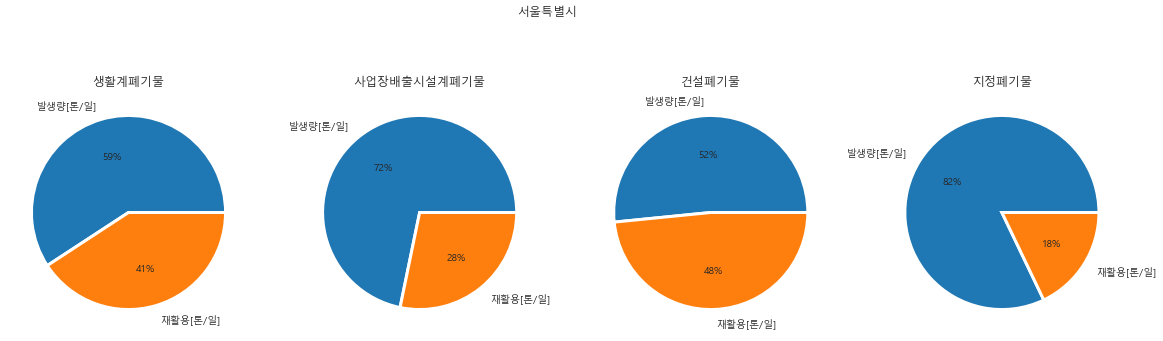

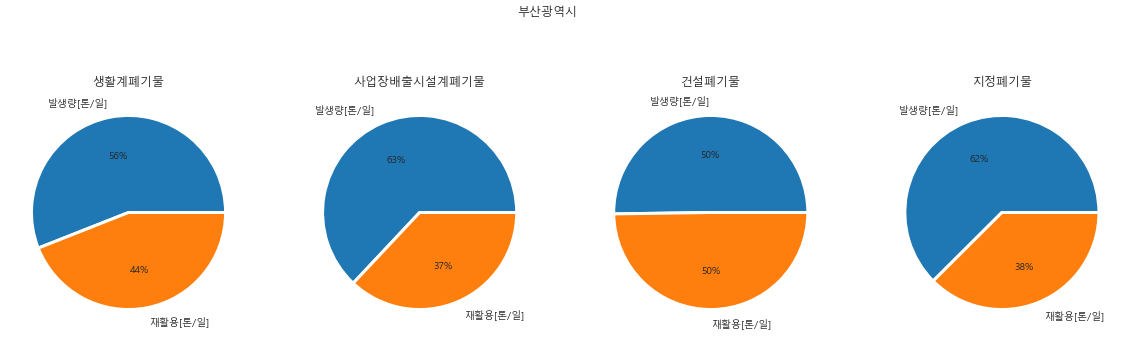

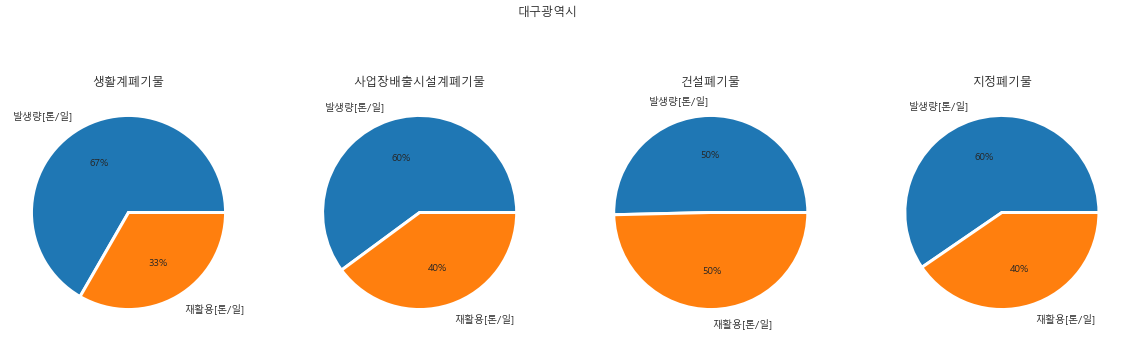

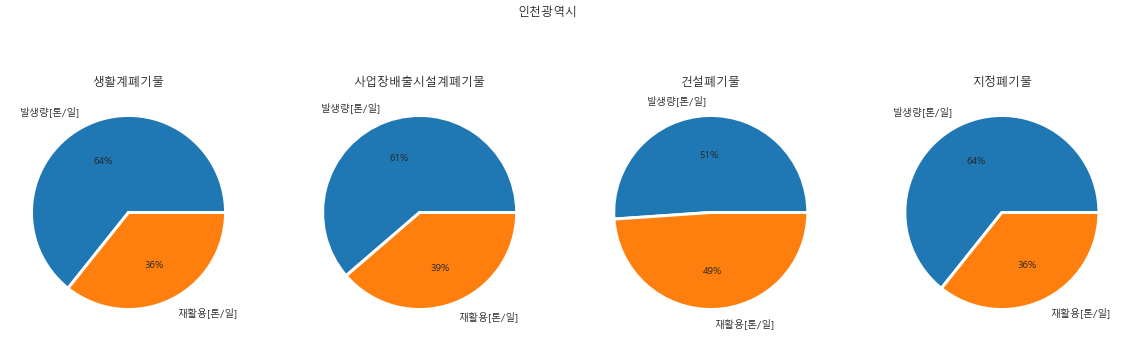

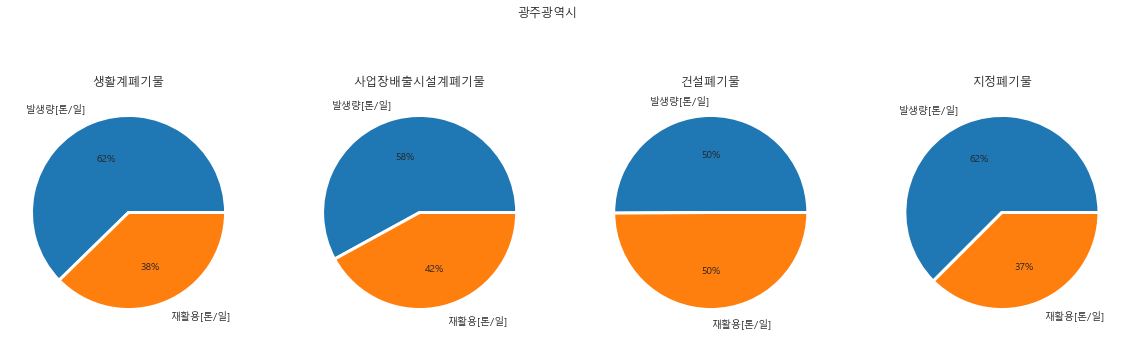

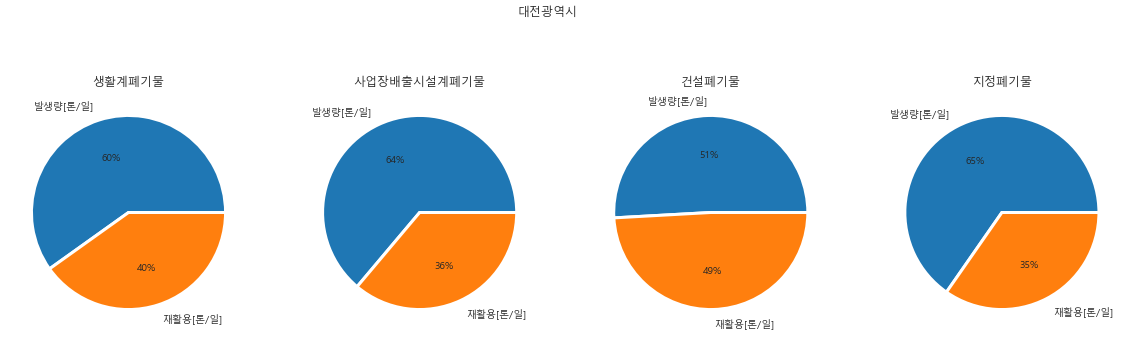

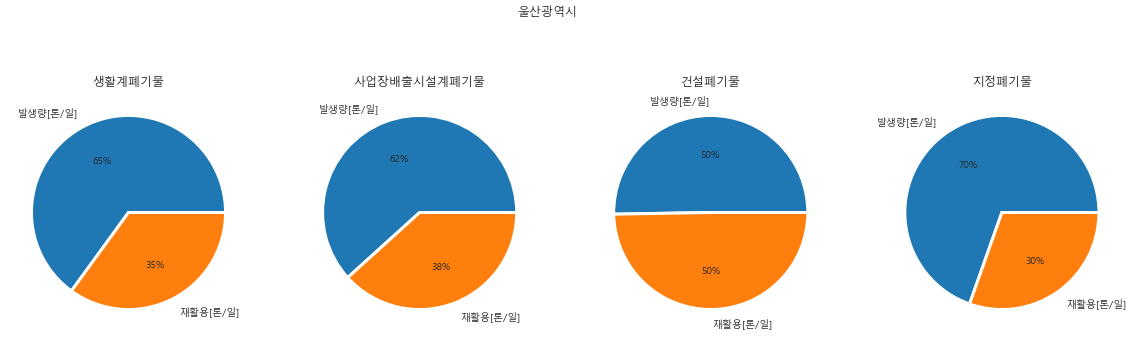

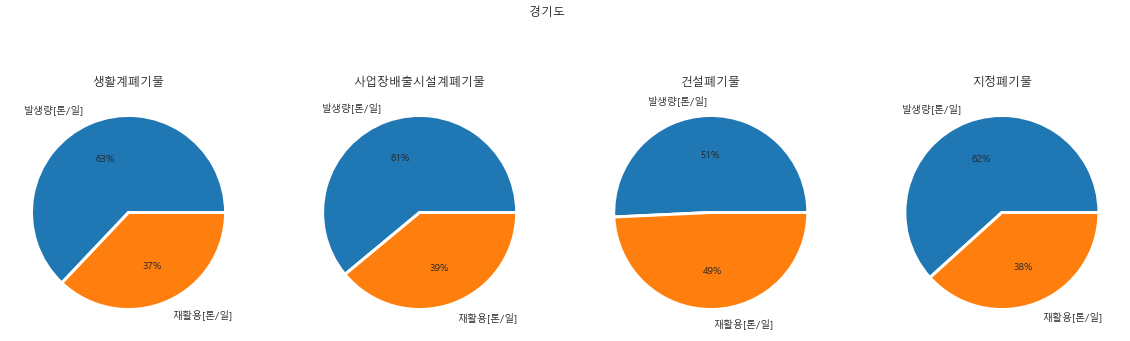

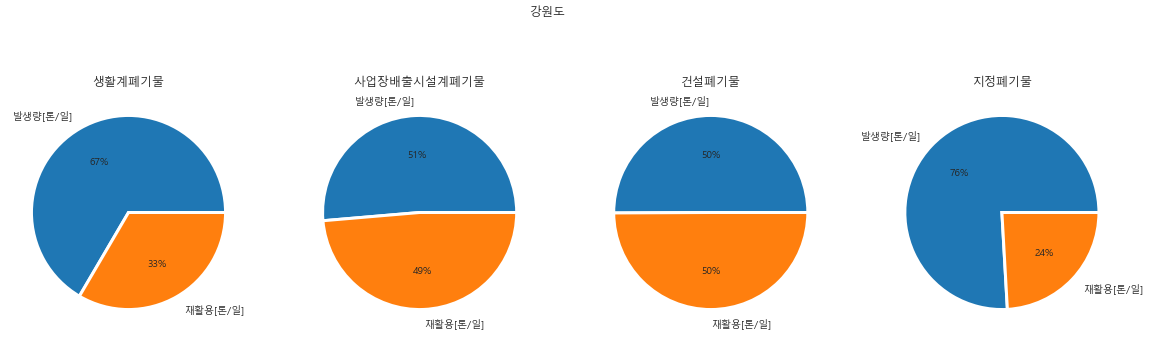

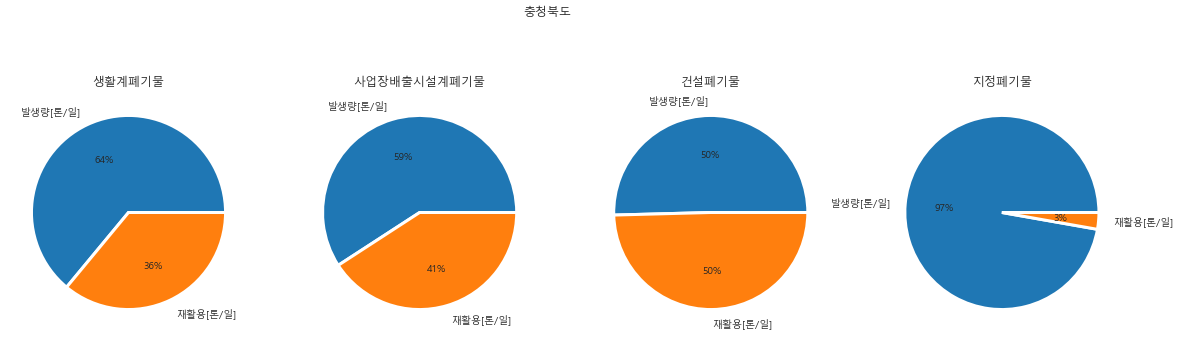

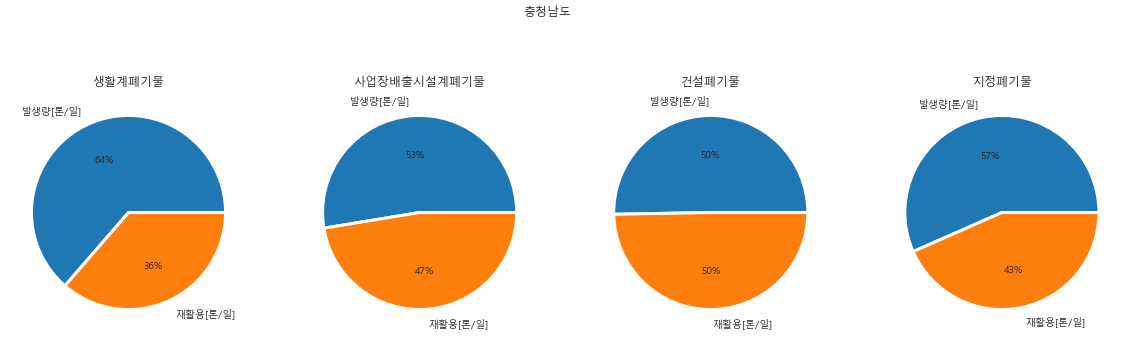

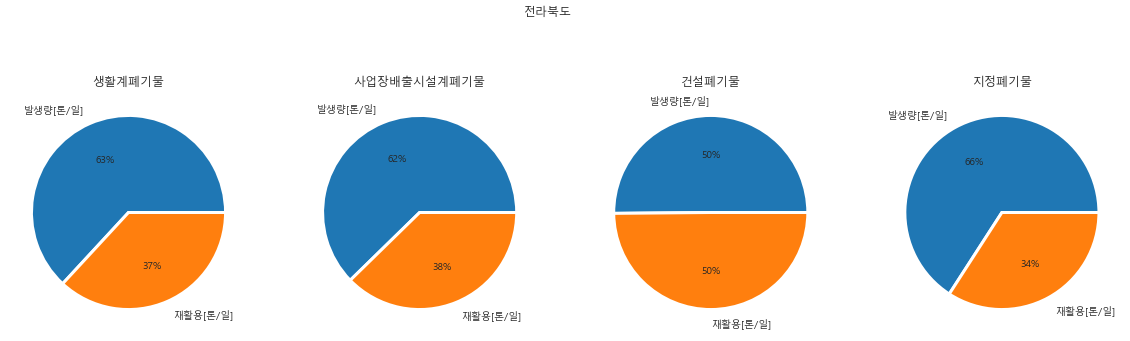

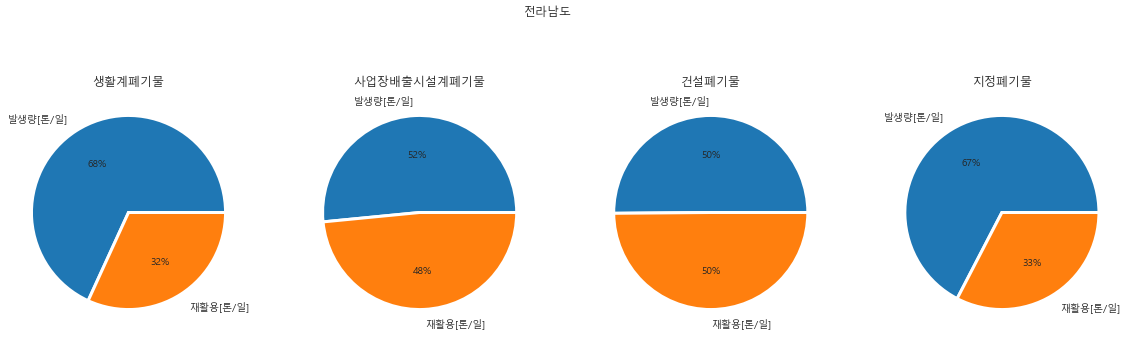

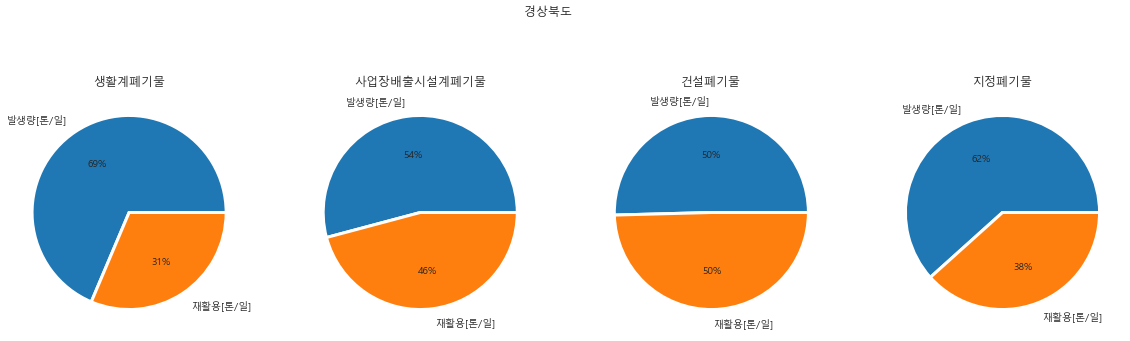

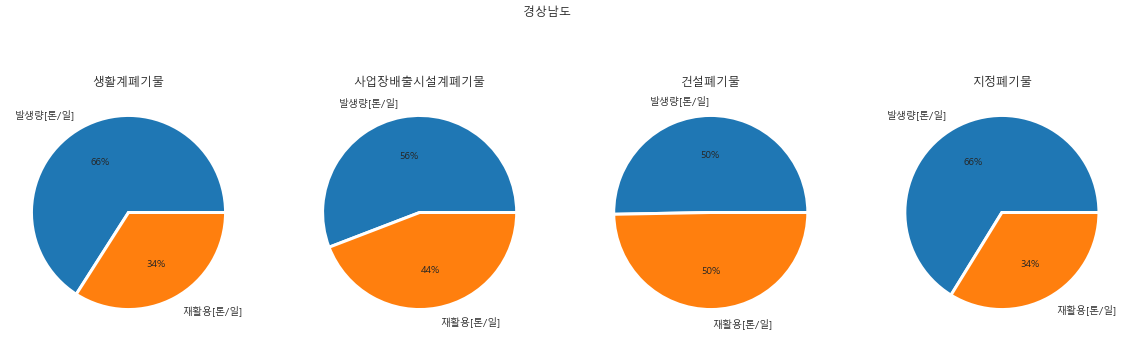

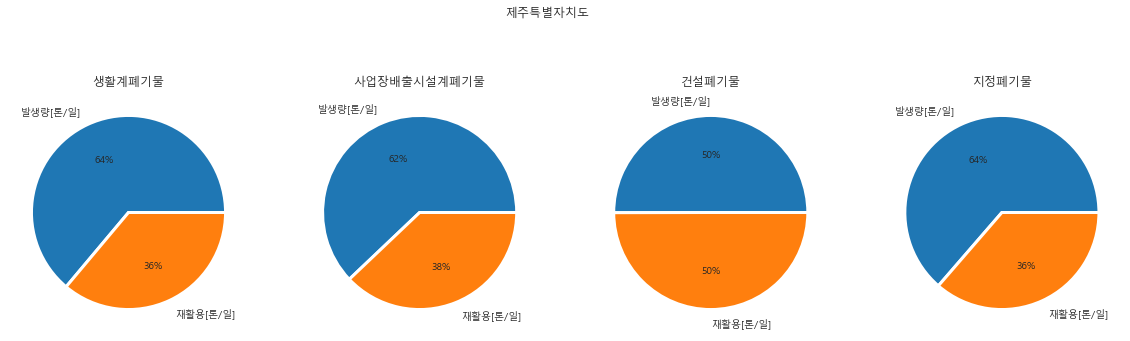

In [68]:
# create random data
y ='2020'

def draw_pie(year):
    for i in data2_sido['행정구역별'].unique():
        filtered = data2_sido.loc[(data2_sido['년도'].str.match(year)&data2_sido['행정구역별'].str.match(i))].copy()
        fig,axes = plt.subplots(ncols=4,nrows=1,figsize=(20,6))
        fig.suptitle(i)
        for i,d in enumerate(filtered.values):
            names=['발생량[톤/일]', '재활용[톤/일]']
            values=d[3:5]
            axes[i].set_title(d[1])
            axes[i].pie(values, labels=names,autopct='%.0f%%', labeldistance=1.15, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' })
draw_pie('2015')

In [ ]:
# Create a pieplot
# plt.pie(size_of_groups)

# Label distance: gives the space between labels and the center of the pie
# plt.pie(values, labels=names, labeldistance=1.15, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' })
# plt.show()



# fig, axs = plt.subplots(5, 4, figsize=(24, 24))
# ax, ay = 0, 0

# for i in data1['지역'].unique():
#     sido_condition = data1['지역']== i
#     df_temp = data1[sido_condition].groupby(data1['년도'])[['값']].sum().reset_index()

#     if ay==4:
#         ax+=1
#         ay=0
#     axs[ax, ay].bar(df_temp['년도'], df_temp['값'], color='#8B4513')
#     axs[ax, ay].plot(df_temp['년도'], df_temp['값'], color='#FF6347', marker='o')
#     axs[ax, ay].set_title('{}의 연도별 추세'.format(i))
#     axs[ax, ay].spines['top'].set_visible(False)
#     axs[ax, ay].spines['right'].set_visible(False)
#     axs[ax, ay].tick_params(bottom=False)
#     ay+=1

# for sax in axs.flat:
#     sax.set_yticks(list(range(0, 9000, 1000)))
#     # sax.set_xticks(list(data1['년도'].unique()))

# plt.suptitle('시도별 총폐기물량 연도별 추세', fontsize=20, weight='bold')
# fig.subplots_adjust(top=0.95)
# plt.show()

In [56]:
# file3 전처리

data3 = file3.transpose()  #전치
data3 = data3.reset_index() #인덱스초기화

var = [str(elem)[0:4] for elem in data3['index'].values] #년도 정제
data3['년도'] = var #년도 컬럼추가

# #인덱스, 컬럼명 정리
data3 = data3.drop('index', axis=1) 
data3 = data3[['년도',0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]]
data3.columns = ['년도', '종류1', '종류2', '합계', '서울','부산','대구','인천','광주','대전', '울산','세종','경기','강원','충북','충남','전북','전남','경북','경남','제주']
data3 = data3.drop([0], axis = 0)

# 총계, 소계 행 삭제
con2 = data3[data3['종류1'] == '총계'].index
data3.drop(con2, inplace=True)
con22 = data3[data3['종류2'] == '소계'].index
data3.drop(con22, inplace=True)

# #인덱스 초기화
data3 = data3.reset_index()
data3 = data3.drop('index', axis=1)
data3 = data3.drop('합계', axis=1)

# melt
data3 = data3.melt(id_vars=['년도', '종류1', '종류2'])
data3.columns = ['년도', '종류1', '종류2', '지역', '값']

condition = data3['종류2']=='매립'
data3_temp_1 = data3[condition].rename(columns={'값':'매립'}).drop(columns=['종류2'])

condition = data3['종류2']=='소각'
data3_temp_2 = data3[condition].rename(columns={'값':'소각'}).drop(columns=['종류2'])

condition = data3['종류2']=='재활용'
data3_temp_3 = data3[condition].rename(columns={'값':'재활용'}).drop(columns=['종류2'])

data3_join = pd.merge(data3_temp_1, data3_temp_2)
data3_join = pd.merge(data3_join, data3_temp_3)

data3_join.head(10)

data3 = data3_join

In [57]:
# tidy data csv 파일로 저장
this_file_path = get_file_dir('refined','폐기물_발생현황_생활계폐기물_생활폐기물_사업장생활계폐기물(10-19).csv')
data1.to_csv(this_file_path, index=False)
this_file_path = get_file_dir('refined','폐기물 재활용률(09-18).csv')
data2.to_csv(this_file_path, index=False)
this_file_path = get_file_dir('refined','폐기물_처리주체별_처리현황_생활계폐기물_생활폐기물_사업장생활계폐기물(10-19).csv')
data3.to_csv(this_file_path, index=False)

# 저장 확인
pd.read_csv(this_file_path)


,년도,종류1,지역,매립,소각,재활용
0,2010,지방자치단체,서울,962.2,1180.9,3047.6
1,2010,위탁처리업체,서울,483.5,801.1,3544.0
2,2010,자가처리업체,서울,0.0,0.0,1.1
3,2011,지방자치단체,서울,663.7,1517.3,3002.0
4,2011,위탁처리업체,서울,438.7,827.2,2991.2
...,...,...,...,...,...,...
505,2018,위탁처리업체,제주,0.0,0.0,561.8
506,2018,자가처리업체,제주,0.0,0.0,0.0
507,2019,지방자치단체,제주,84.3,369.7,290.0
508,2019,위탁처리업체,제주,0.2,11.9,458.0


### 2.0 데이터 개요 

In [ ]:
f_w_path = get_file_dir('refined','폐기물_발생현황_생활계폐기물_생활폐기물_사업장생활계폐기물(10-19).csv')
data1 = pd.read_csv(f_w_path, encoding='CP949')
f_w_path = get_file_dir('refined','폐기물 재활용률(09-18).csv')
data2 = pd.read_csv(f_w_path, encoding='CP949')
f_w_path = get_file_dir('refined','폐기물_처리주체별_처리현황_생활계폐기물_생활폐기물_사업장생활계폐기물(10-19).csv')
data3 = pd.read_csv(f_w_path, encoding='CP949')

1. .info(), .head(), .describe() 등 데이터 전반 내용 확인

In [ ]:
data1

,년도,배출방식,종류1,종류2,지역,값
0,2010,종량제 방식에 의한 혼합 배출,가연성,음식물류폐기물,서울,10.9
1,2010,종량제 방식에 의한 혼합 배출,가연성,폐지류,서울,700.8
2,2010,종량제 방식에 의한 혼합 배출,가연성,폐목재류,서울,199.4
3,2010,종량제 방식에 의한 혼합 배출,가연성,폐고무류,서울,140.9
4,2010,종량제 방식에 의한 혼합 배출,가연성,플라스틱류,서울,366.0
...,...,...,...,...,...,...
1882,2019,재활용가능자원 분리배출,폐합성수지류,발포수지류,제주,1.0
1883,2019,재활용가능자원 분리배출,폐합성수지류,PET병,제주,16.6
1884,2019,재활용가능자원 분리배출,폐합성수지류,기타,제주,12.8
1885,2019,재활용가능자원 분리배출,영농폐기물,농약용기류,제주,0.0


In [ ]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1887 entries, 0 to 1886
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   년도      1887 non-null   object
 1   배출방식    1887 non-null   object
 2   종류1     1887 non-null   object
 3   종류2     1887 non-null   object
 4   지역      1887 non-null   object
 5   값       1887 non-null   object
dtypes: object(6)
memory usage: 88.6+ KB


In [ ]:
data1.describe()

,값
count,1887.000000
mean,127.461049
std,214.679088
min,0.000000
25%,19.800000
50%,53.100000
75%,149.400000
max,2183.200000


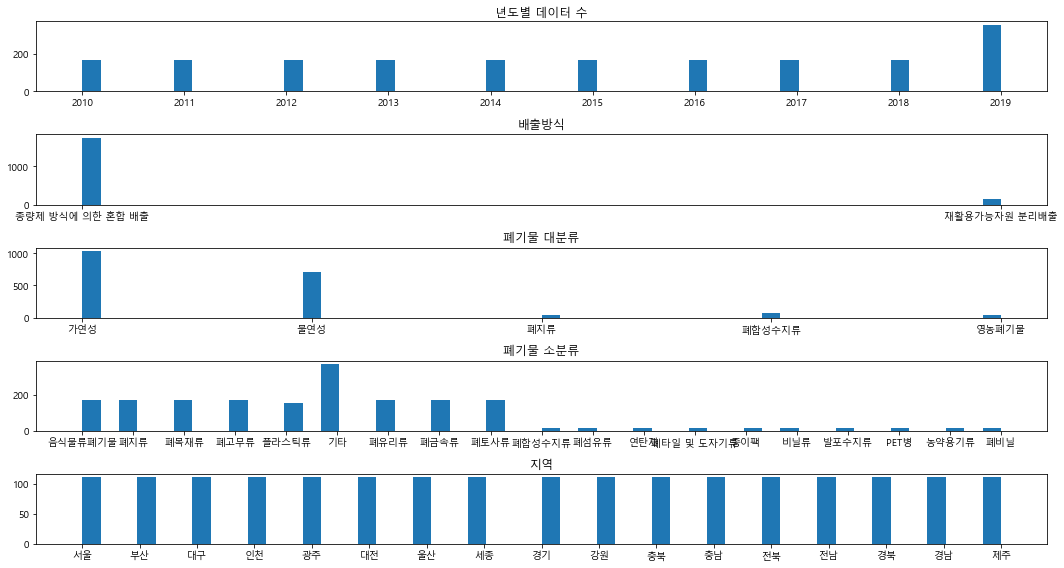

In [ ]:
plt.figure(figsize=(15,8))

plt.subplot(5,1,1)
plt.hist(data1['년도'], bins=50)
plt.title('년도별 데이터 수')

plt.subplot(5,1,2)
plt.hist(data1['배출방식'], bins=50)
plt.title('배출방식')

plt.subplot(5,1,3)
plt.hist(data1['종류1'], bins=50)
plt.title('폐기물 대분류')

plt.subplot(5,1,4)
plt.hist(data1['종류2'], bins=50)
plt.title('폐기물 소분류')

plt.subplot(5,1,5)
plt.hist(data1['지역'], bins=50)
plt.title('지역')

plt.tight_layout()

In [ ]:
# data1 = data1.replace('', '0')
# data1 = data1.astype({'값':float})
sum1 = data1.groupby(['년도', '지역'])['값'].sum()
sum1 = pd.DataFrame(sum1)

값
년도   지역        
2010 강원  1280.1
     경기  4584.3
     경남  1636.9
     경북  1322.5
     광주   524.5
...         ...
2019 전남  1456.9
     전북  1187.7
     제주   712.0
     충남  1783.7
     충북  1466.9

[170 rows x 1 columns]

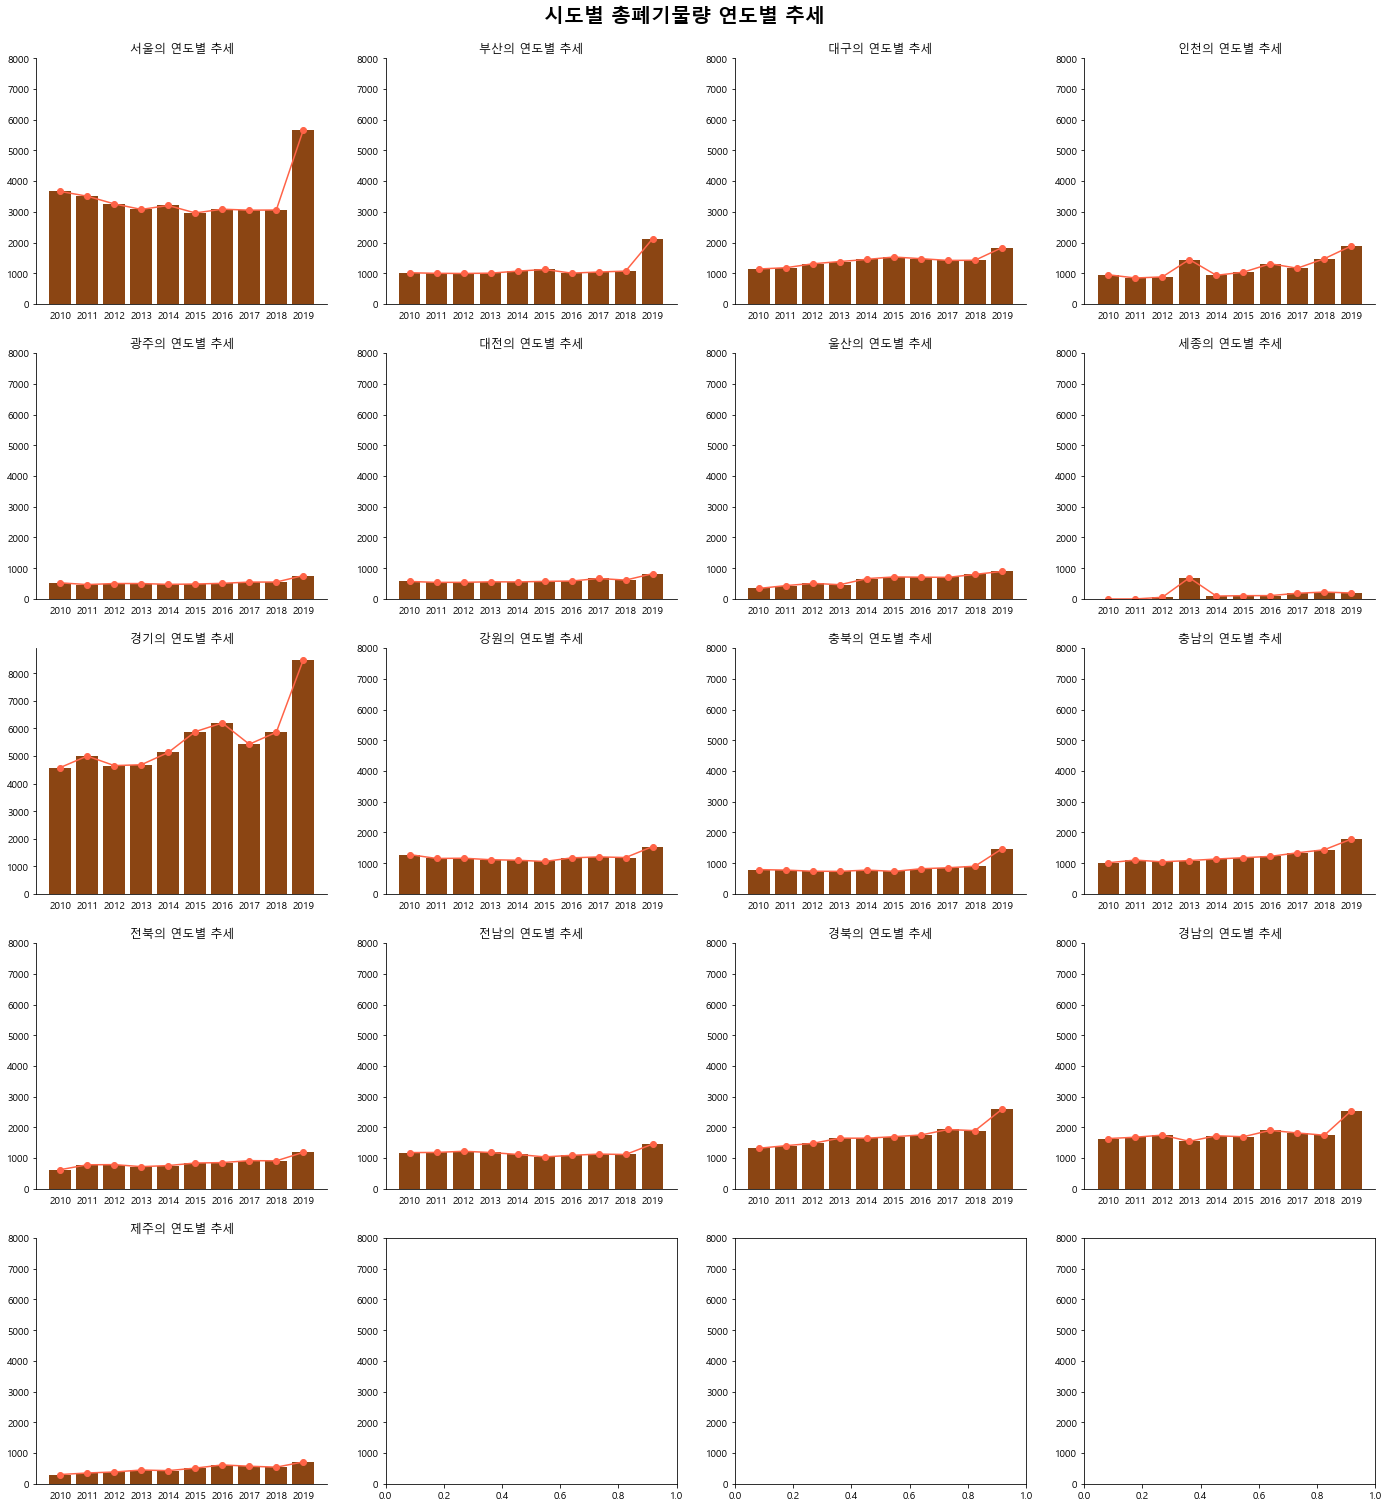

In [ ]:
# 시도별 총폐기물량 연도별 추세

fig, axs = plt.subplots(5, 4, figsize=(24, 24))

ax, ay = 0, 0

for i in data1['지역'].unique():
    sido_condition = data1['지역']== i
    df_temp = data1[sido_condition].groupby(data1['년도'])[['값']].sum().reset_index()

    if ay==4:
        ax+=1
        ay=0
    axs[ax, ay].bar(df_temp['년도'], df_temp['값'], color='#8B4513')
    axs[ax, ay].plot(df_temp['년도'], df_temp['값'], color='#FF6347', marker='o')
    axs[ax, ay].set_title('{}의 연도별 추세'.format(i))
    axs[ax, ay].spines['top'].set_visible(False)
    axs[ax, ay].spines['right'].set_visible(False)
    axs[ax, ay].tick_params(bottom=False)
    ay+=1

for sax in axs.flat:
    sax.set_yticks(list(range(0, 9000, 1000)))
    # sax.set_xticks(list(data1['년도'].unique()))

plt.suptitle('시도별 총폐기물량 연도별 추세', fontsize=20, weight='bold')
fig.subplots_adjust(top=0.95)
plt.show()

In [ ]:
# data2 = data2.replace('-', '0')
# data2 = data2.astype({'값':float})

print(data2.head(20))
data2.info()
data2.describe()

    행정구역별         폐기물별        항목    년도        값
0   서울특별시       생활계폐기물  발생량[톤/일]  2009  11445.0
1   서울특별시       생활계폐기물  재활용[톤/일]  2009   7508.0
2   서울특별시  사업장배출시설계폐기물  발생량[톤/일]  2009   2322.0
3   서울특별시  사업장배출시설계폐기물  재활용[톤/일]  2009    869.0
4   서울특별시        건설폐기물  발생량[톤/일]  2009  31774.0
5   서울특별시        건설폐기물  재활용[톤/일]  2009  30100.0
6   서울특별시        지정폐기물  발생량[톤/일]  2009    214.0
7   서울특별시        지정폐기물  재활용[톤/일]  2009     73.0
8   서울특별시       전년도이월량  발생량[톤/일]  2009      9.0
9   서울특별시      당해년도발생량  발생량[톤/일]  2009    205.0
10    종로구       생활계폐기물  발생량[톤/일]  2009    433.0
11    종로구       생활계폐기물  재활용[톤/일]  2009    273.0
12    종로구  사업장배출시설계폐기물  발생량[톤/일]  2009      0.0
13    종로구  사업장배출시설계폐기물  재활용[톤/일]  2009      0.0
14    종로구        건설폐기물  발생량[톤/일]  2009    645.0
15    종로구        건설폐기물  재활용[톤/일]  2009    610.0
16    종로구        지정폐기물  발생량[톤/일]  2009      3.0
17    종로구        지정폐기물  재활용[톤/일]  2009      1.0
18    종로구       전년도이월량  발생량[톤/일]  2009      0.0
19    종로구      당해년도발생량  발생량[톤/일]  2009  

,값
count,2.438500e+04
mean,8.841749e+03
std,9.793576e+04
min,0.000000e+00
25%,1.340000e+01
50%,1.624000e+02
75%,6.888000e+02
max,4.902572e+06


In [4]:
data2[['항목','값']].T

NameError: name 'data2' is not defined

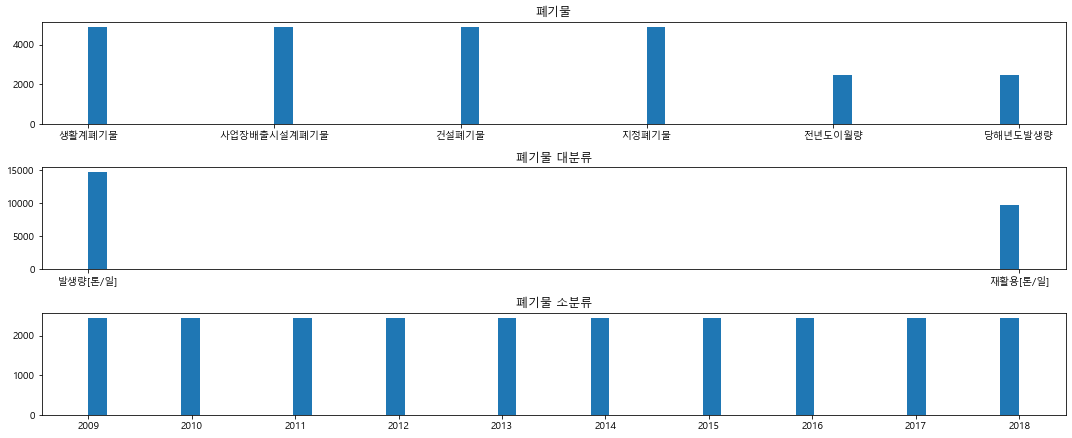

In [203]:
# 항목별 데이터 수 

plt.figure(figsize=(15,8))

plt.subplot(4,1,2)
plt.hist(data2['폐기물별'], bins=50)
plt.title('폐기물')

plt.subplot(4,1,3)
plt.hist(data2['항목'], bins=50)
plt.title('폐기물 대분류')

plt.subplot(4,1,4)
plt.hist(data2['년도'], bins=50)
plt.title('폐기물 소분류')

plt.tight_layout()

In [219]:
# data3 = data3.replace('-', '0')
# data3 = data3.astype({'값':float})

print(data3.head(10))
data3.info()
data3.describe()

     년도     종류1  종류2  지역       값
0  2010  지방자치단체   매립  서울   962.2
1  2010  지방자치단체   소각  서울  1180.9
2  2010  지방자치단체  재활용  서울  3047.6
3  2010  위탁처리업체   매립  서울   483.5
4  2010  위탁처리업체   소각  서울   801.1
5  2010  위탁처리업체  재활용  서울  3544.0
6  2010  자가처리업체   매립  서울     0.0
7  2010  자가처리업체   소각  서울     0.0
8  2010  자가처리업체  재활용  서울     1.1
9  2011  지방자치단체   매립  서울   663.7
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1581 entries, 0 to 1580
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   년도      1581 non-null   object 
 1   종류1     1581 non-null   object 
 2   종류2     1581 non-null   object 
 3   지역      1581 non-null   object 
 4   값       1581 non-null   float64
dtypes: float64(1), object(4)
memory usage: 61.9+ KB


,값
count,1581.000000
mean,327.786970
std,648.407647
min,0.000000
25%,0.100000
50%,35.400000
75%,419.100000
max,5480.100000


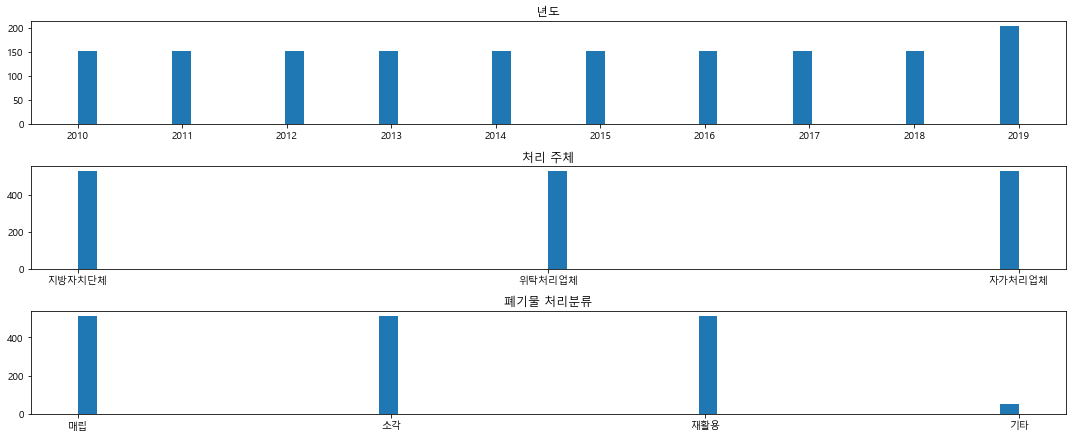

In [222]:
# 항목별 데이터 수 

plt.figure(figsize=(15,8))

plt.subplot(4,1,2)
plt.hist(data3['년도'], bins=50)
plt.title('년도')

plt.subplot(4,1,3)
plt.hist(data3['종류1'], bins=50)
plt.title('처리 주체')

plt.subplot(4,1,4)
plt.hist(data3['종류2'], bins=50)
plt.title('폐기물 처리분류')

plt.tight_layout()

### 3.0 시각적 EDA

데이터 분포, 널값 비율, 또는 데이터 특성이 나타나는 항목 등 시각화 필요한 부분 시각화